## **Fine-tuning AlexNet**

## **Preprocessing del Dataset**

Il preprocessing delle immagini sarà simile a quello effettuato nell'**Esercizio 1**, che include operazioni come l'**equalizzazione** delle immagini e il **cropping della ROI** (spazio intrarticolare), per migliorare la qualità dell'immagine e focalizzarsi sull'area di interesse.

Inoltre, le immagini verranno adattate al formato che **AlexNet** si aspetta, ovvero ridimensionate a **224x224 pixel** e convertite in formato **RGB**, dato che il modello è stato pre-addestrato su immagini a colori (ImageNet). Verrà inoltre effettuata la **normalizzazione** dei pixel, in modo da allinearsi con i parametri di addestramento del modello pre-addestrato.

Per affrontare il problema dell'**unbalancing** del dataset, sono state  applicate inizialmente due soluzioni: l'uso di **class weights** (come nell'Esercizio 1) e l'uso della **Data Augmentation**, come richiesto dalla consegna. Quest'ultima tecnica è stata aggiunta dopo aver eseguito delle prove senza di essa, utilizzando solo i class weights. Durante questi test, si è notato che i risultati miglioravano significativamente con la Data Augmentation, che oltre a generare nuove varianti delle immagini di addestramento e quindi migliorare la generalizzazione del modello, hanno risolto il problema dello sbilanciamento delle classi. Per questo motivo, è stato deciso di includere la Data Augmentation nel modello finale.





In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Definizione del percorso del dataset scaricato
dataset_path = "/content/drive/MyDrive/KOA Dataset/archive"

os.chdir(f'{dataset_path}')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/KOA Dataset/archive'

### **Importazione delle librerie e fissaggio dei semi**

In questa cella, sono stati importati i moduli necessari di PyTorch, oltre ai classici moduli utilizzati negli esercizi di Data Science. Inoltre, sono stati fissati i semi (SEED) per garantire la riproducibilità del codice. Questo significa che, eseguendo più volte il codice, i risultati saranno gli stessi ogni volta, assicurando coerenza ad ogni run.

In [7]:
# Moduli di PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Altri Moduli
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix


# Fisso il seed per la riproducibilità
seed = 42

# Fisso il seed per Python
random.seed(seed)

# Fisso il seed per NumPy
np.random.seed(seed)

# Fisso il seed per PyTorch
torch.manual_seed(seed)

# Fisso il seed per CUDA (GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Impostazioni per la riproducibilità su GPU
torch.backends.cudnn.deterministic = True

# Impostazione dei colori per i grafici utilizzando la colormap "viridis"
colors = plt.cm.viridis([0.1, 0.3, 0.5, 0.7, 0.9])  # 5 colori diversi (5 classi) equidistanti



# Disabilito tutti i warning per migliorare la leggibilità dell'output
import warnings
warnings.filterwarnings("ignore")

# Elenco dei set di dati presenti (train, validation, test, auto-test)
sets = ["train", "val", "test", "auto_test"]

### **Unione set**
Come fatto nel precedente esercizio, unisco tutti i set di dati in un unico dataset per generare lo split che desidero. Ho deciso di non utilizzare lo split fornito dal dataset originale, in quanto ho preferito gestire autonomamente la suddivisione.

In [8]:
# Unisco tutti i set in un unico dataset
all_images = []
all_labels = []

for set_name in sets:
    set_path = os.path.join(dataset_path, set_name)
    for class_label in os.listdir(set_path):
        class_path = os.path.join(set_path, class_label)
        images = os.listdir(class_path)
        all_images.extend([os.path.join(class_path, img) for img in images])
        all_labels.extend([int(class_label)] * len(images))

print(f"Numero totale di immagini: {len(all_images)}")
print(f"Numero totale di etichette: {len(all_labels)}")


Numero totale di immagini: 9786
Numero totale di etichette: 9786


### **Distribuzioni classi**
Come si può notare, e come è stato visto precedentemente, il dataset risulta essere molto sbilanciato. In particolare, scarseggia la classe 4, quella con il grado di severità maggiore, mentre la classe 0, che rappresenta il ginocchio sano, è molto più numerosa.
Questo problema verrà affrontato e risolto successivamente.

Distribuzione delle classi:
Classe 4: 295 immagini
Classe 1: 1770 immagini
Classe 2: 2578 immagini
Classe 0: 3857 immagini
Classe 3: 1286 immagini


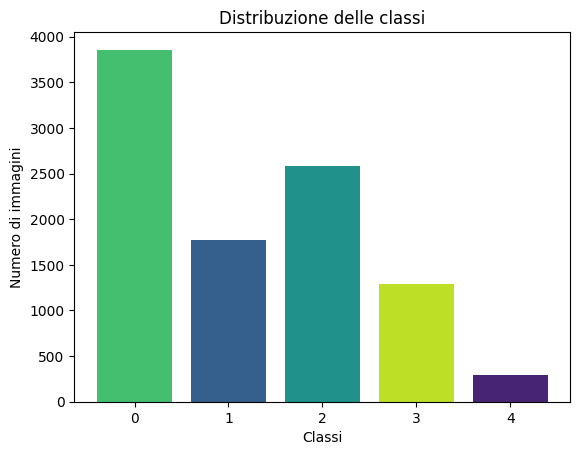

In [9]:
# Controllo distribuzione delle classi
label_counts = Counter(all_labels)
print("Distribuzione delle classi:")
for label, count in label_counts.items():
    print(f"Classe {label}: {count} immagini")

# Visualizzazione delle statistiche
fig, ax = plt.subplots()
ax.bar(label_counts.keys(), label_counts.values(), color=colors)
ax.set_title("Distribuzione delle classi")
ax.set_xlabel("Classi")
ax.set_ylabel("Numero di immagini")
plt.xticks(list(label_counts.keys()))
plt.show()

### **Lettura delle Immagini**

In questa sezione, le immagini vengono inizialmente lette in **scala di grigi**, poiché il dataset originale è costituito da immagini monocromatiche. Successivamente, è stato effettuato un **cropping** mirato per estrarre l'area di interesse, ovvero lo spazio intraarticolare del ginocchio, allo stesso modo dell'esercizio precedente.

Le immagini nel dataset presentano una **grande variabilità di luminosità e contrasto**, che potrebbe influire negativamente sull'accuratezza del modello. Per questo motivo, è stata applicata una **equalizzazione dell'istogramma**, con l'obiettivo di standardizzare il contrasto e la luminosità, in modo da ottenere immagini più uniformi e facilitare l'addestramento del modello.

Successivamente, le immagini vengono **ridimensionate a 224x224 pixel**, dimensione richiesta per l'input dell'architettura **AlexNet**. Infine, per adattarsi al formato richiesto da AlexNet, le immagini in scala di grigi vengono **convertite a 3 canali RGB**, assicurando che l'input sia compatibile con il modello, che si aspetta immagini a colori.

In [10]:
# Dataset con immagini e etichette
dataset = []

# Lettura delle immagini
for set_name in sets:
    set_path = os.path.join(dataset_path, set_name)
    for class_label in os.listdir(set_path):
        class_path = os.path.join(set_path, class_label)
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            # Leggi l'immagine con OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Scala di grigi

            # ROI
            roi = img[48:-48, 10:-10]

            # Equalizzazione l'istogramma
            equalized = cv2.equalizeHist(roi)

            # Ridimensionamento dell'immagine a 224x224
            equalized = cv2.resize(equalized, (224, 224), interpolation=cv2.INTER_AREA)

            # Conversione dell'immagine in scala di grigi in un'immagine con 3 canali (richiesto come input di AlexNet)
            image = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)

            dataset.append((image, int(class_label)))

images, labels = zip(*dataset)

### **Splitting del Dataset**

In questa fase, si è deciso di non utilizzare la **cross-validation**, sebbene inizialmente fosse una scelta desiderata (come visto precedentemente). La motivazione dietro questa decisione risiede nel fatto che, allenando il modello per ogni fold, il processo sarebbe diventato estremamente lungo e oneroso in termini di tempo.

Pertanto è stato adottato il metodo di **holdout**. A differenza del precedente esercizio, questa volta è stato deciso di riservare solo il **10%** del dataset per ciascuno dei due split. La ragione di questa scelta è legata alla necessità di avere una **quantità maggiore di immagini per il training**, poiché le **reti neurali deep** necessitano un training set ampio.

Il processo di splitting è stato strutturato in due fasi principali:
1. **Train-Test Split**: inizialmente, il dataset è stato diviso in **90% per il training** e **10% per il test**.
2. **Train-Validation Split**: successivamente, la porzione di training è stata ulteriormente suddivisa in **90% per il training effettivo** e **10% per la validazione**.

Questa strategia consente di avere una base di dati sufficiente per allenare il modello in modo robusto, pur mantenendo una porzione adeguata di dati per la validazione e il test, che saranno utilizzati per monitorare la performance e valutare l'accuratezza finale del modello.

Un aspetto importante da sottolineare è che questo **splitting è stato eseguito prima di qualsiasi bilanciamento delle classi**. Questo approccio garantisce che i **set di validazione e test** mantengano distribuzioni **reali**, che riflettono il mondo reale. Se avessi bilanciato i dati prima di effettuare lo split, i set di validazione e test avrebbero avuto una distribuzione **artificiale**, poiché avrebbero riflesso una **distribuzione bilanciata** che non rispecchia la realtà dei dati.

In [11]:
# Percentuale del validation e test set
validation_size = 0.10
test_size = 0.10


# Split stratificato tra train e test
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels,
    test_size=test_size,
    stratify=labels,
    random_state=42
)

# Split stratificato tra train e validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=validation_size,
    stratify=train_labels,
    random_state=42
)

# Verifica delle dimensioni
print(f"Immagini per il training: {len(train_images)}")
print(f"Immagini per la validazione: {len(val_images)}")
print(f"Immagini per il test: {len(test_images)}")


Immagini per il training: 7926
Immagini per la validazione: 881
Immagini per il test: 979


In questa fase, sono state implementate ulteriori **trasformazioni** per adattare le immagini ai requisiti di AlexNet.

Le **trasformazioni** includono:
1. **Conversione in immagine PIL**: questa operazione è necessaria poiché la conversione in tensore, richiede l'uso dell'immagine come oggetto PIL prima di essere applicata.
2. **Conversione in tensore PyTorch**: una volta che l'immagine è stata convertita in PIL, essa viene trasformata in un tensore torch (formato utilizzato da PyTorch). Questo passaggio inoltre normalizza i valori dell'immagine nell'intervallo [0, 1].
3. **Normalizzazione**: i valori dei pixel delle immagini vengono poi standardizzati utilizzando media e deviazione standard predefiniti (documentazione: https://pytorch.org/hub/pytorch_vision_alexnet/
).

(Quando i dati non sono normalizzati, i valori dei pixel possono variare ampiamente, causando un'**alta variabilità nelle scale** tra i vari input. Questo può portare al problema del **gradiente esplosivo** o **gradiente vanescente**, dove i valori dei gradienti calcolati durante la retropropagazione possono diventare troppo grandi o troppo piccoli, rendendo difficile l'aggiornamento dei pesi in modo efficace.)


In [12]:
import PIL

# Trasformazioni
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Converte l'immagine in un'immagine PIL (serve per ToTensor)
    transforms.ToTensor(),  # Converte l'immagine in tensore PyTorch e normalizza i valori in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standardizzazione
])

validation_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Converte l'immagine in un'immagine PIL (serve per ToTensor)
    transforms.ToTensor(),  # Converte l'immagine in tensore PyTorch e normalizza i valori in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standardizzazione
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Converte l'immagine in un'immagine PIL (serve per ToTensor)
    transforms.ToTensor(),  # Converte l'immagine in tensore PyTorch e normalizza i valori in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standardizzazione
])

# Classe dataset per creare i set
class KneeOsteoarthritisDataset(Dataset):
    def __init__(self, image, labels, transform=None):
        self.image = image
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### **Class Unbalancing, Downsampling e Data Augmentation**

Dopo aver effettuato lo split del dataset, mantenendo distribuzioni di classi simili tra i set di Training, Validation e Test, è stato evidente che il **training set risultava**, ovviamente, **fortemente sbilanciato**. In particolare, le classi 0 e 2 maggiormente rappresentate, predominano di molto rispetto alla classe 4 (come già visto). Un tale sbilanciamento avrebbe potuto comportare una distorsione nell'apprendimento del modello, che tenderebbe a focalizzarsi sulle classi più abbondanti, trascurando quelle meno rappresentate.

Per risolvere questa problematica, è stato implementato un approccio che combina **downsampling** delle classi maggioritarie e **upsampling/data augmentation** .

Dopo varie combinazioni del numero di immagini per classi si è notato che per le reti testate la classificazione dei *casi estremi* (classe 0 no artrosi e classe 4 artrosi grave) risultava più semplice e estremamente buona essendo le due classi più facilmente distinguibili.
Allo stesso tempo il modello incontrava maggiori difficoltà nel classificare i *gradi intermedi* di osteoartrosi.
Per questo motivo successivamente si è deciso di utilizzare un numero di immagini leggermente maggiore per tali classi (1500 classi intermedie vs 1300 classi estreme).


#### *Downsampling delle classi maggioritarie*
Le classi 0 e 2 sono state ridotte a **1300 immagini e 1500 rispettivamente** tramite un processo di downsampling randomico, mantenendo un numero sufficiente di esempi per ciascuna classe e considerando la distinzione tra caso estremo e caso intermedio.

#### *Upsampling della classe 1,3 e 4 tramite Data Augmentation*
Le classi 1,3 (casi intermedi) e 4 (caso estremo) sono state soggette ad **upsampling** per arrivare rispettivamente a 1500, 1500 e 1300. Per aumentare il numero di esempi disponibili, è stata inizialmente applicata una **trasformazione flip left-right** alle immagini di queste classi. Successivamente, per completare il set fino al raggiungimento del numero desiderato, sono state introdotte le restanti  immagini generate tramite **una lieve rotazione** delle immagini originali nel range di -10 a +10 gradi.

Le tecniche di **data augmentation** applicate sono state selezionate in modo da essere pienamente compatibili con il task. In particolare, la **flip left-right** si è rivelata una scelta appropriata, in quanto, specchiando l'immagine, si ottiene una versione simmetrica dell'articolazione del ginocchio. Questo permette di ottenere una rappresentazione equivalente, ad esempio, passando da un ginocchio destro a un ginocchio sinistro, senza introdurre distorsioni anatomiche.

#### *Scelta di 1300 e 1500*
Il numero di **immagini per classe** è stato scelto con l'obiettivo di ottenere un buon bilanciamento nel training set, evitando però di espandere troppo il dataset. Un aumento eccessivo del numero di immagini avrebbe comportato tempi di addestramento significativamente più lunghi, oltre a introdurre una quantità eccessiva di dati sintetici, che avrebbero potuto influire negativamente sulla qualità del modello. Pertanto,quello scelto è stato un compromesso ideale per garantire un addestramento efficace, mantenendo al contempo una distribuzione bilanciata e un modello capace di generalizzare in modo robusto.

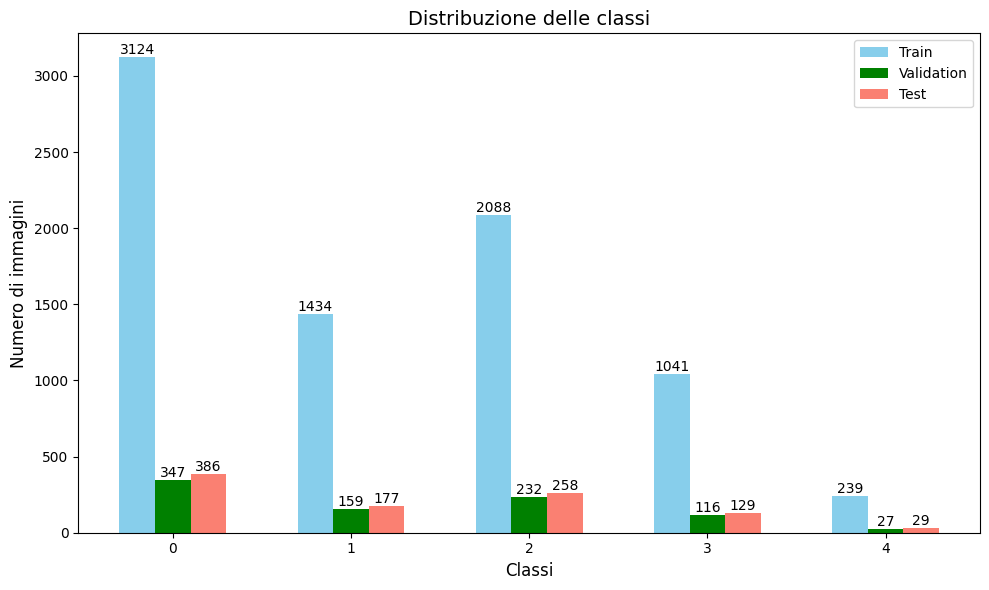

In [13]:
# Conto delle classi nel train, validation e test set
train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

# Creo un array per tutte le classi
classes = sorted(list(train_label_counts.keys()))  # Ordina le classi per sicurezza

# Larghezza delle barre
width = 0.2

# Posizioni delle barre
x = np.arange(len(classes))  # Posizioni base

x_train = x - width  # Barre per il train set
x_val = x            # Barre per il validation set
x_test = x + width   # Barre per il test set

# Creo il barplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot del train set
train_bar = ax.bar(x_train, [train_label_counts[cls] for cls in classes],
                   color="skyblue", width=width, label="Train")

# Plot del validation set
val_bar = ax.bar(x_val, [val_label_counts.get(cls, 0) for cls in classes],
                 color="green", width=width, label="Validation")

# Plot del test set
test_bar = ax.bar(x_test, [test_label_counts.get(cls, 0) for cls in classes],
                  color="salmon", width=width, label="Test")

# Aggiungo i numeri sopra le barre
for bars in [train_bar, val_bar, test_bar]:
    for rect in bars:
        height = rect.get_height()
        if height > 0:  # Mostra il numero solo per barre con altezza > 0
            ax.text(rect.get_x() + rect.get_width() / 2, height,
                    f'{height}', ha='center', va='bottom', fontsize=10)

# Imposto titolo e assi
ax.set_title("Distribuzione delle classi", fontsize=14)
ax.set_xlabel("Classi", fontsize=12)
ax.set_ylabel("Numero di immagini", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [14]:
# Funzione per l'augmentazione delle immagini (flip e rotazione) usando OpenCV
def augment_images(images, max_count=1000):
    augmented_images = images[:]

    # Flip left-right
    def flip_left_right(image):
        return cv2.flip(image, 1)

    # Controllo quante immagini abbiamo dopo il flip
    while len(augmented_images) < max_count:
        for img in images:
            flipped = flip_left_right(img)
            augmented_images.append(flipped)

            if len(augmented_images) >= max_count:
                break

    # Se non abbiamo ancora raggiunto il numero massimo, applico la rotazione
    if len(augmented_images) < max_count:
        for img in images:
            angle = random.uniform(-10, 10)  # Angolo casuale tra -10 e +10 gradi
            height, width = img.shape[:2]
            center = (width // 2, height // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(img, rotation_matrix, (width, height))
            augmented_images.append(rotated)

            if len(augmented_images) >= max_count:
                break

    return augmented_images[:max_count]


# Filtro le immagini per le classi
class_3_images = [img for img, label in zip(train_images, train_labels) if label == 3]
class_4_images = [img for img, label in zip(train_images, train_labels) if label == 4]
class_0_images = [img for img, label in zip(train_images, train_labels) if label == 0]
class_1_images = [img for img, label in zip(train_images, train_labels) if label == 1]
class_2_images = [img for img, label in zip(train_images, train_labels) if label == 2]

# Downsampling per 0 e 2
class_0_images = random.sample(class_0_images, 1300)
class_2_images = random.sample(class_2_images, 1500)

# Augmentazione per le classi 1,3 e 4
augmented_class_1_images = augment_images(class_1_images, max_count=1500)
augmented_class_3_images = augment_images(class_3_images, max_count=1500)
augmented_class_4_images = augment_images(class_4_images, max_count=1300)

# Unire le immagini selezionate per tutte le classi (downsampling + augmentazione)
downsampled_train_images = class_0_images + augmented_class_1_images + class_2_images + augmented_class_3_images + augmented_class_4_images

# Creare le etichette corrispondenti
downsampled_train_labels = [0] * len(class_0_images) + [1] * len(augmented_class_1_images) + [2] * len(class_2_images) + [3] * len(augmented_class_3_images) + [4] * len(augmented_class_4_images)

# Controllare il numero totale di immagini dopo il downsampling e augmentazione
print(f"Numero totale di immagini nel train set dopo downsampling e augmentazione: {len(downsampled_train_images)}")

Numero totale di immagini nel train set dopo downsampling e augmentazione: 7100


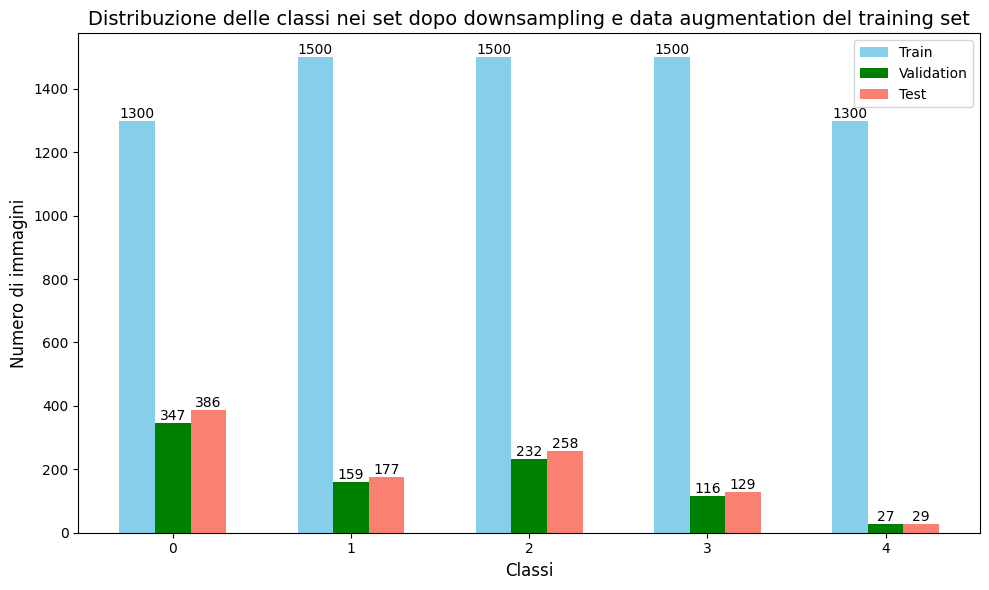

In [15]:
# Conteggio delle etichette nel train set (con downsampling e augmentazione)
downsampled_train_label_counts = Counter(downsampled_train_labels)

# Conto le etichette nel validation set
val_label_counts = Counter(val_labels)

# Conto le etichette nel test set
test_label_counts = Counter(test_labels)

# Creo un array per tutte le classi
classes = sorted(list(downsampled_train_label_counts.keys()))  # Ordina le classi per sicurezza

# Larghezza delle barre
width = 0.2

# Posizioni delle barre
x = np.arange(len(classes))  # Posizioni base

# Posizione delle barre
x_train = x - width  # Barre per il train set
x_val = x            # Barre per il validation set
x_test = x + width   # Barre per il test set

# Creo il barplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot del train set (con downsampling e augmentazione)
train_bar = ax.bar(x_train, [downsampled_train_label_counts[cls] for cls in classes],
                   color="skyblue", width=width, label="Train")

# Plot del validation set
val_bar = ax.bar(x_val, [val_label_counts.get(cls, 0) for cls in classes],
                 color="green", width=width, label="Validation")

# Plot del test set
test_bar = ax.bar(x_test, [test_label_counts.get(cls, 0) for cls in classes],
                  color="salmon", width=width, label="Test")

# Aggiungere i numeri sopra le barre
for bars in [train_bar, val_bar, test_bar]:
    for rect in bars:
        height = rect.get_height()
        if height > 0:  # Mostra il numero solo per barre con altezza > 0
            ax.text(rect.get_x() + rect.get_width() / 2, height,
                    f'{height}', ha='center', va='bottom', fontsize=10)

# Imposto titolo e assi
ax.set_title("Distribuzione delle classi nei set dopo downsampling e data augmentation del training set", fontsize=14)
ax.set_xlabel("Classi", fontsize=12)
ax.set_ylabel("Numero di immagini", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

Come si può notare, il **training set** è stato bilanciato. Tuttavia, i **validation** e **test set** conservano le loro distribuzioni originali, che riflettono le proporzioni reali delle classi nel dataset iniziale in modo da valutare le prestazioni del modello su dati che rappresentano meglio le condizioni del mondo reale. In questo modo, il modello viene addestrato su dati bilanciati, ma testato su distribuzioni realistiche, garantendo una valutazione più accurata della sua capacità di generalizzazione.

### **Creazione dei Data Loader**

Sono stati creati i **data loader** per il training, il validation e il test set, i quali hanno il compito di gestire il caricamento dei dati all'interno del modello durante l'addestramento e la valutazione. I data loader permettono di processare i dati in **batch**,fondamentali per migliorare l'efficienza dell'addestramento e ottimizzare l'utilizzo delle risorse di calcolo.

Ho scelto un **batch size** pari a **1024**. Questa decisione è stata presa in considerazione delle seguenti motivazioni:

1. **Compromesso tra stabilità e velocità**:
   - Con batch size più elevati, il modello tendere a convergere più rapidamente grazie a gradienti mediati su più esempi e per questo è meno instabile.
   - Con batch size troppo bassi, invece, i gradienti sarebbero diventati più rumorosi e la convergenza può risultare instabile.

2. **Limiti di memoria**:
   - Un batch size ancora maggiore richiederebbe più memoria GPU (Colab offre poca RAM).

In [16]:
# Dataset
train_dataset = KneeOsteoarthritisDataset(downsampled_train_images, downsampled_train_labels, transform=train_transforms)
val_dataset = KneeOsteoarthritisDataset(val_images, val_labels, transform=validation_transforms)
test_dataset = KneeOsteoarthritisDataset(test_images, test_labels, transform=test_transforms)

# Creazione dei DataLoader per Train, Validation e Test
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

## Modello

Il modello è stato scaricato direttamente con i suoi **pesi pre-addestrati** su ImageNet, impostando `pretrained=True`.

#### Adattamento del modello al task specifico
Analizzando la struttura del modello AlexNet, si è osservato che:

1. **Input a tre canali**:
   - Il primo layer convoluzionale richiede immagini con **3 canali (RGB)** come input, una caratteristica che è stata considerata nel preprocessing, dove le immagini in scala di grigi sono state convertite a RGB.

2. **Output a 1000 classi**:
   - Il layer finale di AlexNet, in configurazione originale, è progettato per classificare 1000 classi presenti nel dataset ImageNet. Poiché il task attuale richiede di classificare le immagini in **5 classi**, questo layer è stato modificato. In particolare, il **fully connected layer finale** è stato sostituito con un layer che produce un output di 5 unità.

Questa modifica consente di utilizzare AlexNet come base per il fine tuning successivo, sfruttando le caratteristiche già apprese sul dataset ImageNet e adattandole al problema specifico, con una significativa riduzione del tempo di addestramento e del rischio di overfitting.

In [17]:
# Struttura di AlexNet pre-addestrata
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
# Modifico l'output per avere 5 classi (1 per ogni grado di severità)
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=5)

# Verifica la struttura del modello
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### **Preparazione per il Fine-Tuning**

Per adattare l'addestramento del modello AlexNet sul task, è stata implementata una strategia di **fine-tuning** che prevede il congelamento selettivo dei layer.

#### *Congelamento iniziale dei layer*
Inizialmente, **tutti i layer del modello sono stati congelati**, sia quelli della sezione convoluzionale (features) che quelli della sezione del classificatore (layer lineari/dense), in modo tale da mantenere i pesi del modello pre-addestrato. Questo è stato ottenuto impostando l'attributo `requires_grad` di tutti i parametri a **`False`**, disabilitando così l'aggiornamento dei pesi durante il processo di backpropagation.

#### *Prima configurazione: Sblocco del classificatore*
 Successivamente, ho deciso di **sbloccare tutto il classificatore**, ovvero gli ultimi tre **fully connected (dense)** layer, impostando `requires_grad=True` per permettere l'addestramento di questi. Di conseguenza:
- I pesi della parte convoluzionale rimanevano **fissi** durante l'addestramento,preservando **tutte** le feature estratte dai dati di ImageNet.
- Solo i layer finali del classificatore venivano addestrati, permettendo loro di adattarsi specificamente alla classificazione dei gradi di severità dell’osteoartrite.

Questo approccio ha permesso di ottenere:
1. **Riduzione del tempo di addestramento**:
   - Congelando i layer convoluzionali, ho evitato il calcolo del gradiente per una grande porzione del modello, velocizzando il training e riducendo i costi computazionali.
   
2. **Adattamento mirato**:
   - Sbloccando solo il classificatore, ho sfruttato le features generalizzate già apprese sul dataset ImageNet, utilizzandole per il nostro specifico task di classificazione delle immagini.

#### *Seconda Configurazione: Sblocco degli ultimi layer convoluzionali e del classificatore*
Successivamente, è stata testata una **seconda configurazione** che prevedeva:
1. **Sblocco degli ultimi due layer convoluzionali**, in aggiunta a quello del classificatore, per consentire al modello di apprendere **nuove** features specifiche al dataset. Sononstati scelti gli ultimi due layer convoluzionali poiché, a differenza dei primi layer (che tendono a estrarre caratteristiche più generali come bordi e luminosità), gli ultimi tendono ad apprendere caratteristiche più specifiche e adatte al task.
   
2. **Differenti learning rate**:
   - Un **learning rate più basso** è stato assegnato agli ultimi due layer convoluzionali, al fine di estrarre feature più specifiche per il task senza alterare drasticamente i pesi pre-addestrati su ImageNet.
   - Un **learning rate più alto** è stato utilizzato per i layer del classificatore, per permettere una rapida adattabilità alla classificazione dei gradi di severità dell'osteoartrite.

#### *Risultati e Decisione Finale*
Le due configurazioni sono state testate e valutate. Dopo aver eseguito i test, è emerso che la configurazione in cui sono stati sbloccati **sia il classificatore che gli ultimi due layer convoluzionali** ha portato a un miglioramento sul test set di circa il **7%** rispetto alla configurazione in cui è stato sbloccato solo il classificatore. Questo miglioramento è stato attribuito alla capacità del modello di apprendere caratteristiche più specifiche e pertinenti per il nostro task, piuttosto che utilizzare esclusivamente le feature generali apprese su ImageNet. Per questo motivo, è stato deciso di mantenere sbloccati anche gli ultimi due layer convoluzionali, ottimizzando così la capacità del modello di adattarsi al nostro specifico problema di classificazione.

In [19]:
for param in alexnet.features.parameters(): # Congelo i pesi di tutti di tutti i layer della parte features extraction (convoluzionali)
    param.requires_grad = False
for param in alexnet.classifier.parameters(): # Sblocco tutto il classificatore
    param.requires_grad = True
for param in alexnet.features[8:].parameters(): # Sblocco gli ultimi 2 layer convoluzionali
    param.requires_grad = True

In [20]:
for name, param in alexnet.named_parameters():
    print(f"{name}: {param.requires_grad}")

features.0.weight: False
features.0.bias: False
features.3.weight: False
features.3.bias: False
features.6.weight: False
features.6.bias: False
features.8.weight: True
features.8.bias: True
features.10.weight: True
features.10.bias: True
classifier.1.weight: True
classifier.1.bias: True
classifier.4.weight: True
classifier.4.bias: True
classifier.6.weight: True
classifier.6.bias: True


## **Training e Validation**

Il training è stato progettato per cercare di massimizzare l'efficienza dell'addestramento ma allo stesso tempo di minimizzare il rischio di overfitting (per quest'ultimo motivo non è garantibile la covergenza sul training ad una soluzione ottimale). Di seguito vengono descritte le scelte chiave effettuate e le motivazioni dietro ogni decisione.

#### *Utilizzo del dispositivo*
Per allenare la rete è stata utilizzata la **GPU**, se disponibile, che permette di effettuare le moltiplicazioni matriciali (per l'update dei pesi) in parallelo. In assenza di una GPU, il modello può comunque essere trainato con la **CPU** con tempi maggiori.

#### *Loss function*
La loss scelta è la **CrossEntropyLoss**, ideale per problemi di classificazione multi-classe come questo. Questa funzione misura la distanza tra le probabilità predette dal modello e le etichette vere.
Essendo la superficie della loss nell'iper-spazio dei pesi molto irregolare e complessa (soprattutto per task multi-classe), si sono testati vari *learnig rate* partendo da quelli più alti favorendo così la velocità di convergenza a quelli più bassi che invece hanno permesso una migliore esplorazione della superficie della loss. Dopo vari tentativi di hyperparameter tuning si è scelto il learning rate che permettesse di avere il valor minimo sulla loss del validation.


#### *Optimizer e regularizer*
È stato utilizzato l'optimizer **Adam**, noto per la sua efficienza (rispetto a SGD) nel convergere rapidamente anche con un learning rate più basso. Inoltre per ridurre ulteriormente il rischio di overfitting, è stata aggiunta una **regolarizzazione L2** con un peso (`weight_decay`) pari a **1e-5**, che penalizza i pesi troppo grandi.

#### *Scheduler per il learning rate*
È stato anche adottato un **scheduler per il learning rate**, che riduce il learning rate del 90% (`factor=0.1`) quando la perdita di validazione non migliora per **3 epoche consecutive**. Questa ha permesso di adattare dinamicamente il ritmo di apprendimento, permettendo al modello di fare piccoli aggiustamenti quando si avvicina alla convergenza.

#### *Early Stopping*
Infine è stato utilizzato anche l'**early stopping** per interrompere l'addestramento qualora la loss sul validation non migliorasse per **6 epoche consecutive**. Questo approccio riduce il rischio di overfitting e risparmia soprattutto tempo computazionale evitando ulteriori epoche inutili.

In [21]:
# Definizione del dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

# Definizione della funzione di perdita
criterion = nn.CrossEntropyLoss()

# Creo una lista di parametri per ciascun gruppo (classificatore, ultimi due layer convoluzionali)
params_to_update = [ {'params': alexnet.classifier.parameters(), 'lr': 1e-3},  # Learning rate più alto per il classificatore
                     {'params': alexnet.features[8:].parameters(), 'lr': 1e-4} ] # Learning rate più basso per features extractor

# Creo l'ottimizzatore con regolarizzazione L2
optimizer = optim.Adam(params_to_update, weight_decay=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early Stopping
best_val_loss = float('inf')  # Validation loss migliore
patience = 6  # Numero massimo di epoche senza miglioramenti
epochs_without_improvement = 0


- Durante ogni epoca, il modello è stato addestrato su tutti i batch del training set. Per ogni batch:
  - i gradienti sono stati calcolati e i pesi aggiornati.
  - è stata calcolata **loss** per monitorare durante il training la qualità della classificazione.
  - è stata calcolata l'**accuracy** per confrontare le predizioni con le etichette reali.
- Per la validazione:
  - Il modello è stato posto in modalità `eval`. Di solito esso si usa per disabilitare dropout e batch normalization che però non sono presenti in AlexNet, ma è comunque buona pratica attivarlo durante la validazione.
  - Sono stati calcolati la loss e l'accuracy sul validation set senza aggiornare i parametri.
- Il modello migliore (quello con la loss minima di validazione) è stato salvato per il testing successivo.

In [22]:
# Numero di epoche
num_epochs = 30

# Salvo la loss e l'accuracy per il training e la validazione
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Loop di training
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validazione
    alexnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(alexnet.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%")

Epoch 1/30, Train Loss: 2.8597, Train Acc: 22.01%, Validation Loss: 1.8067, Validation Acc: 3.06%
Epoch 2/30, Train Loss: 1.4771, Train Acc: 30.59%, Validation Loss: 1.4278, Validation Acc: 25.43%
Epoch 3/30, Train Loss: 1.2335, Train Acc: 41.56%, Validation Loss: 1.1867, Validation Acc: 47.33%
Epoch 4/30, Train Loss: 1.1108, Train Acc: 48.34%, Validation Loss: 1.1430, Validation Acc: 50.51%
Epoch 5/30, Train Loss: 1.0262, Train Acc: 52.73%, Validation Loss: 1.1176, Validation Acc: 44.49%
Epoch 6/30, Train Loss: 0.9598, Train Acc: 55.10%, Validation Loss: 1.0679, Validation Acc: 54.03%
Epoch 7/30, Train Loss: 0.8972, Train Acc: 59.82%, Validation Loss: 1.1580, Validation Acc: 44.15%
Epoch 8/30, Train Loss: 0.8286, Train Acc: 62.37%, Validation Loss: 1.1043, Validation Acc: 43.25%
Epoch 9/30, Train Loss: 0.7671, Train Acc: 65.62%, Validation Loss: 1.0738, Validation Acc: 50.96%
Epoch 10/30, Train Loss: 0.7372, Train Acc: 67.99%, Validation Loss: 1.0794, Validation Acc: 53.12%
Epoch 11/3

### Curve di Loss e Accuracy

Di seguito vengono riportati i grafici delle curve di **loss** e **accuracy** sia per il training che per la validazione, ottenuti durante l'addestramento.

#### *Curve del Training*
Come si può osservare, durante le epoche la **loss** sul training diminuisce progressivamente, mentre l'**accuracy** aumenta come previsto. Questo comportamento è atteso, poiché il modello apprende progressivamente a classificare correttamente le immagini del training set. Tuttavia, nonostante la convergenza, i valori finali di accuracy e loss sul training non sono estremamente elevati. Questo risultato è dovuto alle tecniche di **regolarizzazione** applicate, tra cui la penalizzazione L2, il learning rate basso e l'early stopping. Queste scelte hanno limitato la capacità del modello di adattarsi eccessivamente ai dati del training, garantendo così un miglior bilanciamento tra il fitting sui dati di training e la capacità di generalizzare su dati non visti.

Prove preliminari effettuate con learning rate più alti e senza regolarizzazione hanno mostrato valori migliori sul training, ma con una drastica perdita di performance sul validation set, evidenziando un chiaro **overfitting**. Di conseguenza, la configurazione finale è stata ottimizzata per garantire una buona generalizzazione.

#### *Curve del Validation*
Per quanto riguarda il validation set, si nota come la **loss** diminuisca nelle prime epoche per poi stabilizzarsi in un **plateau**. Questo comportamento è tipico quando il modello raggiunge un punto in cui non riesce più a migliorare significativamente la sua capacità di generalizzare sui dati di validazione.

Per quanto riguarda l'**accuracy** sul validation set, si osserva un miglioramento rispetto alle epoche iniziali. Tuttavia, la curva risulta piuttosto **instabile** durante l'addestramento. Questo comportamento è attribuibile a due motivi principali:
1. **Dataset sbilanciato**: l'accuracy non è una buona metrica per set sblianciati dato che non tiene conto della distribuzione delle classi.
2. **Minore rappresentatività statistica**: essendo il validation set significativamente più piccolo del training set, piccole variazioni nei risultati possono portare a oscillazioni nei valori di accuratezza.

Nonostante ciò, rispetto alle prime epoche, si osserva un chiaro miglioramento sia in termini di loss che di accuracy sul validation set, confermando che il modello è stato in grado di imparare e allo stesso tempo generalizzare.

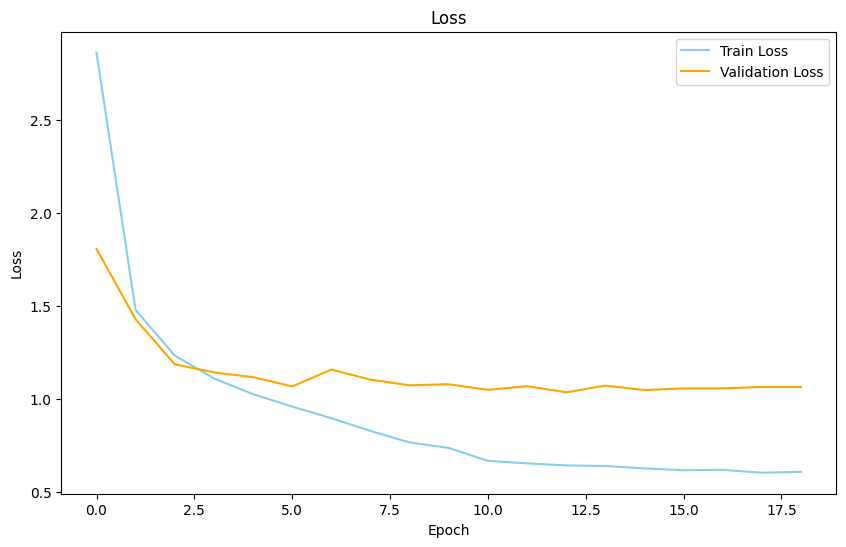

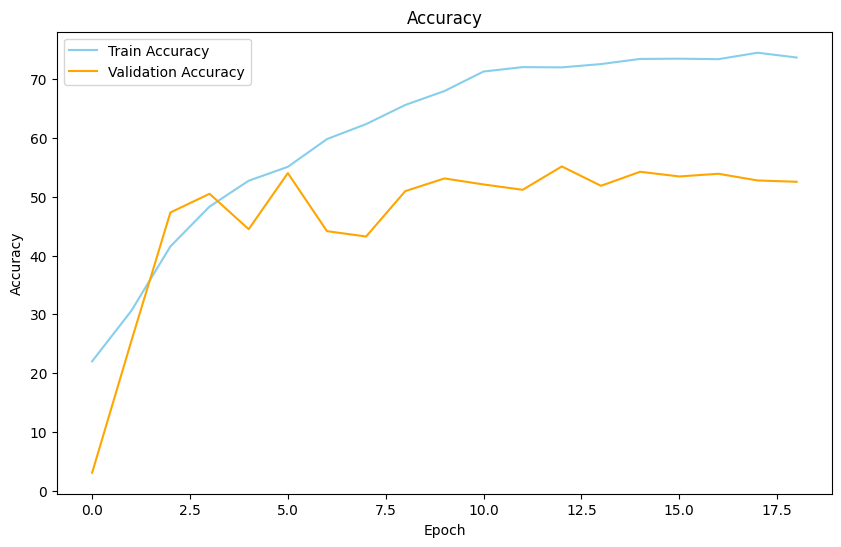

In [25]:
# Plot della loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="skyblue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot dell'accuratezza
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Train Accuracy", color="skyblue")
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test

#### *Caricamento del Miglior Modello*
Per la fase di testing, è stato utilizzato il modello salvato durante l'addestramento, corrispondente all'epoca in cui la loss di validazione ha raggiunto il valore minimo. Questo dovrebbe assicurare che il modello testato rappresenti il massimo livello di generalizzazione ottenuto durante l'addestramento.

N.B: tra tutte le configurazioni di preprocessing e sblocco dei layer, si è scelta quella con i risultati più bilanciati tra le classi (sono riuscito a raggiungere anche il 60% di accuracy ma prediceva malissimo classi 1 e 2)

#### *Testing*
Durante il testing, il modello è stato impostato in modalità di inference, e soono state calcolate le seguenti metriche:
- **Loss sul test set**
- **Accuracy sul test set**

#### *Confusion Matrix*
Per valutare le prestazioni del modello in modo più dettagliato, è stata inoltre calcolata la matrice di confusione. Questa matrice fornisce una rappresentazione chiara dei risultati di classificazione, evidenziando:
- Il numero di esempi classificati correttamente per ciascuna classe.
- Gli errori di classificazione, ovvero i casi in cui il modello ha predetto una classe errata.

La matrice è stata normalizzata rispetto al totale degli esempi di ogni classe, per bilanciare gli effetti dovuti alla distribuzione non uniforme delle classi nel dataset.


Test Loss: 1.0548, Test Acc: 52.30%


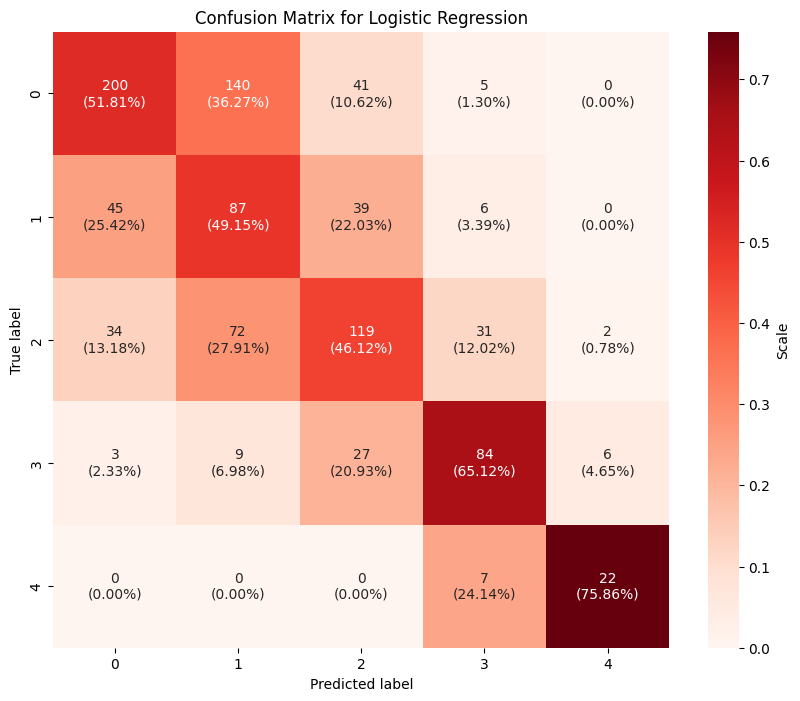

In [26]:
# Carico il miglior modello salvato
alexnet.load_state_dict(torch.load('best_model.pth'))
alexnet.to(device)


# Test
alexnet.eval()
test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Aggiungo le etichette e le predictions alle liste
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcolo la loss e l'accuratezza
test_loss = test_loss / len(test_loader)
test_accuracy = 100. * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# Calcolo la matrice di confusione
cm = confusion_matrix(all_labels, all_predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_norm[i, j] * 100
        s = f"{c}\n({p:.2f}%)"
        annot[i, j] = s

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Reds', cbar_kws={'label': 'Scale'}, ax=ax, square=True)
ax.set_title('Confusion Matrix for Logistic Regression')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

## **Risultati**

I risultati ottenuti confermano che il modello ha mantenuto una discreta capacità di generalizzazione. La loss sul test set si è rivelata migliore rispetto alle prime fasi dell'addestramento e l'accuratezza si è dimostrata in linea con quanto osservato in validazione, indicando che il modello non ha sofferto di overfitting.

### *Analisi delle prestazioni: Confusion Matrix*

Analizzando la **confusion matrix** dei risultati finali, si evidenziano miglioramenti significativi rispetto alle configurazioni precedenti (no sblocco layer convoluzionali e no data augmentation). In esse, il modello aveva una **buona classificazione per la classe 0 (sana) e la classe 4 (grave)**, mentre la performance sulle classi intermedie (1, 2, 3) risultava decisamente inferiore. Con la configurazione finale, che prevede lo sblocco del classificatore e degli ultimi due layer convoluzionali (e del balancing 1300 e 1500), si osserva un quadro più bilanciato:

- La classificazione della classe 4 rimane **buona**, con una precisione elevata nel rilevare i casi più gravi.
- La classificazione della classe 0 risulta **leggermente peggiorata** rispetto alla configurazione iniziale, con una percentuale significativa di immagini predette erroneamente come classe 1.
- Le classi intermedie (1, 2, 3) mostrano un **miglioramento considerevole**, con una maggiore accuratezza nel distinguere le differenze tra i gradi intermedi di osteoartrite.

#### *Comportamento del modello sulla classe 0*
Un'analisi più dettagliata mostra che la classe 0 viene predetta come classe 1 (dubbia) nel **36,27%** dei casi. Questo comportamento, sebbene un errore, può essere considerato **vantaggioso a livello di indagine clinica**. Infatti, classificare un caso sano come dubbio o malato porta a una **recall più alta** e a una riduzione dei falsi negativi. In un contesto clinico, è preferibile individuare erroneamente un caso come dubbio o sospetto piuttosto che classificare una persona sana e successivamente scoprire che presenta una patologia non rilevata.

#### *Comportamento del modello sulle classi intermedie (1, 2, 3)*
Per le classi intermedie (1, 2, 3), il modello mostra una **discreta precisione nel classificare correttamente** i gradi specifici di osteoartrite. Tuttavia, si osserva un comportamento tipico nei modelli di classificazione ordinali come questo: quando il modello sbaglia, tende a classificare le immagini nelle **classi adiacenti**. Ad esempio:
- La classe 1 viene spesso predetta come classe 0 o classe 2.
- La classe 2 viene confusa con la classe 1 o la classe 3.
- La classe 3 viene associata in alcuni casi alla classe 2 o alla classe 4.

Questo comportamento è ragionevole, poiché le differenze visive tra i gradi intermedi di osteoartrite sono spesso sottili e più difficili da distinguere rispetto ai casi estremi (0 e 4). Tuttavia, il miglioramento osservato nelle percentuali di classificazione corretta delle classi intermedie dimostra che il modello, grazie al fine-tuning mirato, ha appreso a distinguere più efficacemente anche alcune sfumature di queste categorie.


## **Conclusioni**

A seguito del fine-tuning anche di MobileNet (nello script BENEDETTO_HW3_ES_2B.ipynb) si può fare un confronto tra i due approcci utilizzati per classificazione: l'utilizzo di modelli classici di machine learning con **handcrafted features** e il fine-tuning di un modello pre-addestrato (AlexNet/MobileNet). I risultati ottenuti evidenziano vantaggi significativi nell'adozione di una rete neurale convoluzionale pre-addestrata con un fine-tuning rispetto all'approccio tradizionale.

#### *Vantaggi fine-tuning di un modello pre-addestrato*
1. **Performance superiori**: nessun modello nell'esercizio precedente ha superato il 44% sul test (vs 52.30 % con fine tuning)

2. **Feature learning automatizzato**:
   - Contrariamente ai metodi classici basati su handcrafted features, dove le features rilevanti devono essere progettate manualmente e possono risultare sub-ottimali per il task, il modello pre-addestrato ha automaticamente identificato le features visive (grazie allo sblocco degli ultimi due layer) più importanti per la classificazione. Ciò ha permesso di ridurre soprattutto lo sforzo di progettazione e ottimizzazione delle features fatto nel primo eserczio.

3. **Adattabilità e scalabilità**:
   - I modelli pre-addestrati su un vasto dataset come ImageNet, forniscono una solida base di feature generalizzate (nei primi layer). Lo sblocco degli ultimi layer convoluzionali e del classificatore ha permesso di adattare queste feature al nostro task specifico senza dover riprogettare il modello da zero.

#### *Limiti dei modelli basati su handcrafted features*
1. **Dipendenza dall'expertise**:
   - L'estrazione manuale delle feaatures richiede ovviamente conoscenza del dominio (physiological feature extraction nell'es1)
2. **Prestazioni inferiori**:

3. **Rigidità**:
   - Le feature progettate per un task specifico come nell'eserczio 1 non sono facilmente riutilizzabili o adattabili ad altri problemi, al contrario di un modello pre-addestrato che può essere fine-tunato su diversi dataset.

#### *Confronto complessivo*
L'approccio basato sul fine-tuning dei due un modelli pre-addestrati si è dimostrato più efficace e flessibile rispetto all'utilizzo di modelli classici con handcrafted features. Non solo ha migliorato le performance complessive, ma ha anche mostrato maggiore capacità di generalizzazione e adattabilità al task. Questo risultato evidenzia l'importanza delle reti neurali convoluzionali pre-addestrate come strumenti fondamentali per la classificazione di immagini, specialmente in scenari complessi come la diagnosi medica e problemi multi-classe.

